# Imports

In [1]:
from dataclasses import dataclass
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple, Union
from datetime import datetime
import numpy as np
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from scipy.spatial.distance import cdist, hamming

# User Settings

In [2]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    # Bootstrap parameters
    n_bootstrap: int = 100
    bootstrap_size: int = 5_000
    random_seed: int = 42
    
    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# 1. Datengrundlage
## 1.1 Import

In [4]:
cfg = Config()

current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train, df_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

# Entferne Zeilen mit NaN-Werten
len_before = len(df_holdout)
df_holdout = df_holdout.dropna().reset_index(drop=True)
print(f"Removed {len_before - len(df_holdout)} rows with NaN values from holdout set.")

Removed 337 rows with NaN values from holdout set.


## 1.2 Col Description & Target

In [5]:
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['icu_admission_24h', 'gender', 'ethnicity', 'night_arrival', 'weekend_arrival','chief_complaint', 'icd_block']
ord_cols = ['consciousness_level','news_score']
ord_cats = {col: df_train[col].cat.categories.tolist() for col in ord_cols}

# 2. Funktion

## Preprocessing

In [6]:
def preprocess_data(df, num_cols, cat_cols, ord_cols, ord_categories, ohe_fit=None):
    # Numerische & Ordinale Daten: Encoding & Z-Standardisierung
    scaler = StandardScaler()
    processed = {}
    
    # Numerische Daten: Z-Standardisierung
    if num_cols:
        processed['num'] = scaler.fit_transform(df[num_cols])
    else:
        processed['num'] = np.empty((len(df), 0))

    # Ordinale Daten: Ordinal-Encoding
    if ord_cols:
        ordered_categories = [ord_categories[col] for col in ord_cols]
        ord_enc = OrdinalEncoder(categories=ordered_categories)
        ord_encoded = ord_enc.fit_transform(df[ord_cols])
        processed['ord'] = scaler.fit_transform(ord_encoded)
    else:
        processed['ord'] = np.empty((len(df), 0))
    
    # Kategoriale Daten: One-Hot-Encoding
    if cat_cols:
        if ohe_fit is None:
            ohe = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
            ohe_fit = ohe.fit(df[cat_cols])
        processed['cat'] = ohe_fit.transform(df[cat_cols])
    else:
        processed['cat'] = np.empty((len(df), 0))

    return processed, ohe_fit




## Compute NNDR

### Mit Bootstrap und Parallelisierung

In [7]:
def bootstrap_iteration_nndr(query_proc, ref_proc, num_cols, ord_cols, cat_cols, sample_size, rng):
    query_len = query_proc['num'].shape[0] if query_proc['num'].size > 0 else next(iter(query_proc.values())).shape[0]
    ref_len = ref_proc['num'].shape[0] if ref_proc['num'].size > 0 else next(iter(ref_proc.values())).shape[0]

    query_idx = rng.choice(query_len, size=sample_size, replace=True)
    ref_idx = rng.choice(ref_len, size=sample_size, replace=True)

    query_sample = {k: v[query_idx] for k, v in query_proc.items()}
    ref_sample = {k: v[ref_idx] for k, v in ref_proc.items()}

    num_dist = cdist(query_sample['num'], ref_sample['num'], metric='euclidean') if query_sample['num'].shape[1] > 0 else 0
    ord_dist = cdist(query_sample['ord'], ref_sample['ord'], metric='euclidean') if query_sample['ord'].shape[1] > 0 else 0
    if query_sample['cat'].shape[1] > 0:
        cat_dist = cdist(query_sample['cat'], ref_sample['cat'], metric='hamming')
    else:
        cat_dist = 0

    total_features = len(num_cols) + len(ord_cols) + len(cat_cols)
    weights = {
        'num': len(num_cols) / total_features if len(num_cols) > 0 else 0,
        'ord': len(ord_cols) / total_features if len(ord_cols) > 0 else 0,
        'cat': len(cat_cols) / total_features if len(cat_cols) > 0 else 0
    }

    combined_dist = (
        (num_dist * weights['num'] if weights['num'] > 0 else 0) +
        (ord_dist * weights['ord'] if weights['ord'] > 0 else 0) +
        (cat_dist * weights['cat'] if weights['cat'] > 0 else 0)
    )

    sorted_dists = np.sort(combined_dist, axis=1)
    nndr_values = sorted_dists[:, 0] / (sorted_dists[:, 1] + 1e-10)  # +epsilon zur Vermeidung von Division durch 0
    return nndr_values

def compute_nndr_bootstrap(query, reference, num_cols, cat_cols, ord_cols, ord_categories, n_bootstrap=None, sample_size=1_000, random_state=None):
    """
    Für jeden Punkt in query werden die beiden nächstgelegenen Nachbarn in reference bestimmt und daraus d1 und d2 für den NNDR (= d1/d2) berechnet.
    """
    rng = np.random.default_rng(random_state)

    # Preprocessing
    ref_proc, ohe_fit = preprocess_data(reference, num_cols, cat_cols, ord_cols, ord_categories)
    query_proc, _ = preprocess_data(query, num_cols, cat_cols, ord_cols, ord_categories, ohe_fit=ohe_fit) # ohe_fit stellt sich, dass der One-Hot-Encoder alle Kategorien aus beiden Datensätzen kennt
    
    if n_bootstrap is not None:
        all_nndr_values = []
        
        all_nndr_values = Parallel(n_jobs=-1)(
            delayed(bootstrap_iteration_nndr)(
                query_proc, ref_proc, num_cols, ord_cols, cat_cols, sample_size, rng
            ) for seed in tqdm(range(n_bootstrap), desc='Bootstrapping NNDR (parallel)')
        )
    
        # Alle Bootstrapping-Ergebnisse zusammenfassen
        nndr_values_all = np.concatenate(all_nndr_values)

        # Statistische Kennzahlen
        stats = {
            'min': nndr_values_all.min(),
            'q1': np.percentile(nndr_values_all, 25),
            'median': np.median(nndr_values_all),
            'mean': nndr_values_all.mean(),
            'q3': np.percentile(nndr_values_all, 75),
            'max': nndr_values_all.max(),
            'share_below_0.5': (nndr_values_all < 0.5).mean()
        }

        return stats, nndr_values_all
    else:
        print("No bootstrapping not implemented yet.")
        return None, None


## Plot Functions

In [18]:
def plot_nndr_distribution(vals_1, vals_2, label_1, label_2, title='NNDR Distribution', fig_size=(10,6), bins=50, save_fig=False):
    
    plt.figure(figsize=fig_size)

    # 99.5%-Quantil als Grenze für das Clamping
    values_all = np.concatenate([vals_1, vals_2])
    clamp_threshold = np.percentile(values_all, 0.5)

    # Werte anheben (alle Werte < clamp_threshold auf clamp_threshold setzen)
    vals_1_clamped = np.maximum(vals_1, clamp_threshold)
    vals_2_clamped = np.maximum(vals_2, clamp_threshold)

    # Freedman-Diaconis-Regel der Binbreite
    # iqr = np.percentile(values_all, 75) - np.percentile(values_all, 25)
    # bin_width = 2 * iqr / np.cbrt(len(values_all))
    # bins = int((values_all.max() - values_all.min()) / bin_width)
    # bins = max(10, min(bins, 200))  # Sicherheitsgrenze: mindestens 10 und maximal 200 Bins

    values_all_clamped = np.concatenate([vals_1_clamped, vals_2_clamped])
    iqr = np.percentile(values_all_clamped, 75) - np.percentile(values_all_clamped, 25)
    bin_width = 2 * iqr / np.cbrt(len(values_all_clamped))
    bins = int((values_all_clamped.max() - values_all_clamped.min()) / bin_width)
    bins = max(10, min(bins, 200))

    # Histogramm
    sns.histplot(vals_1_clamped, bins=bins, kde=False, label=label_1, stat='density', edgecolor='black', alpha=0.6)
    sns.histplot(vals_2_clamped, bins=bins, kde=False, label=label_2, stat='density', edgecolor='black', alpha=0.6)
    
        # Letztes xtick-Label als "> Schwellenwert" umbenennen
    ax = plt.gca()
    xticks = ax.get_xticks()
    xticks = xticks[xticks >= clamp_threshold]  # nur Ticks innerhalb der Grenze
    if clamp_threshold not in xticks:
        xticks = np.append(xticks, clamp_threshold)  # Clamp-Grenze sicherstellen
    xticks = np.sort(xticks)  # Reihenfolge wieder aufsteigend sortieren
    xticklabels = [f'{tick:.2f}' if tick > clamp_threshold else f'<{clamp_threshold:.2f}' for tick in xticks]
    plt.xticks(xticks, labels=xticklabels)

    # Achsenbeschriftung und Titel
    plt.xlabel('NNDR')
    plt.ylabel('Density')
    plt.title(title)
    plt.tick_params(axis='both')
    plt.legend(loc='upper left')
    # xrange = values_all_clamped.max() - clamp_threshold
    # plt.xlim(clamp_threshold - 0.02 * xrange, values_all_clamped.max() + 0.02 * xrange)
    plt.margins(x=0.01)
    plt.tight_layout()

    if save_fig:
        fname = f'NNDR_n-{cfg.n_bootstrap}_s-{cfg.bootstrap_size}_{current_timestamp}.tiff'
        fullpath = cfg.figures_dir / f'{fname}'
        plt.savefig(
            fullpath,
            dpi=300,
            format='tiff',
            bbox_inches='tight',
            pil_kwargs={'compression': 'tiff_lzw'}
        )
        print(f"Abbildung gespeichert unter: {fullpath}")

    plt.show()


In [24]:
def plot_bootstrap_stabilization(values_all, sample_size, ci_band: bool = True, log_scale: bool = True, title='NNDR Quality', save_fig: bool = False):
    n_bootstrap = len(values_all) // sample_size

    # Kumulative Berechnung von Median, Q1, Q3
    cumulative_median = []
    cumulative_q1 = []
    cumulative_q3 = []

    for i in range(1, n_bootstrap + 1):
        subset = values_all[:i * sample_size]
        cumulative_median.append(np.median(subset))
        cumulative_q1.append(np.percentile(subset, 25))
        cumulative_q3.append(np.percentile(subset, 75))

    # DataFrame für Seaborn
    df_plot = pd.DataFrame({
        'Iteration': np.arange(1, n_bootstrap + 1),
        'Median': cumulative_median,
        'Q1': cumulative_q1,
        'Q3': cumulative_q3
    })

    # Plot
    plt.figure(figsize=(2.4, 1.8))
    sns.lineplot(data=df_plot, x='Iteration', y='Median', label='Median')
    if ci_band:
        plt.fill_between(df_plot['Iteration'], df_plot['Q1'], df_plot['Q3'], alpha=0.3, label='IQR Band')
    if log_scale:
        plt.xscale('log')

    plt.xlabel('Bootstrap Iteration')
    plt.ylabel('NNDR Value')
    plt.title(title)
    plt.ylim(0.8, 1.0)
    # plt.legend(loc='upper right')
    plt.legend().remove()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(axis='both')
    plt.tight_layout()
    if save_fig:
        fname = f'NNDR_Stability_{title}_n-{cfg.n_bootstrap}_s-{cfg.bootstrap_size}_{current_timestamp}.tiff'
        fullpath = cfg.figures_dir / f'{fname}'
        plt.savefig(
            fullpath,
            dpi=300,
            format='tiff',
            bbox_inches='tight',
            pil_kwargs={'compression': 'tiff_lzw'}
        )
        print(f"Abbildung gespeichert unter: {fullpath}")
    plt.show()

# Main Routine

## Synth -> Train
Synthetic = query, Train = reference

In [10]:
stats_syn_train, plot_syn_train = compute_nndr_bootstrap(
    query=df_synth, 
    reference=df_train, 
    num_cols=num_cols, 
    cat_cols=cat_cols, 
    ord_cols=ord_cols, 
    ord_categories=ord_cats, 
    n_bootstrap=cfg.n_bootstrap, 
    sample_size=cfg.bootstrap_size, 
    random_state=cfg.random_seed
)

Bootstrapping NNDR (parallel): 100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


## Synth -> Holdout

In [11]:
stats_syn_holdout, plot_syn_holdout = compute_nndr_bootstrap(
    query=df_synth, 
    reference=df_holdout, 
    num_cols=num_cols, 
    cat_cols=cat_cols, 
    ord_cols=ord_cols, 
    ord_categories=ord_cats, 
    n_bootstrap=cfg.n_bootstrap, 
    sample_size=cfg.bootstrap_size, 
    random_state=cfg.random_seed
)

Bootstrapping NNDR (parallel): 100%|██████████| 100/100 [03:53<00:00,  2.33s/it]


## Holdout -> Train

In [12]:
stats_holdout_train, plot_holdout_train = compute_nndr_bootstrap(
    query=df_holdout, 
    reference=df_train, 
    num_cols=num_cols, 
    cat_cols=cat_cols, 
    ord_cols=ord_cols, 
    ord_categories=ord_cats, 
    n_bootstrap=cfg.n_bootstrap, 
    sample_size=cfg.bootstrap_size, 
    random_state=cfg.random_seed
)

Bootstrapping NNDR (parallel): 100%|██████████| 100/100 [03:53<00:00,  2.33s/it]


## Save Results for Analysis

In [13]:
if cfg.save_data:
    np.savetxt("cache/nndr_plot_syn_train.csv", plot_syn_train, delimiter=";", encoding="utf-8")
    np.savetxt("cache/nndr_plot_syn_holdout.csv", plot_syn_holdout, delimiter=";", encoding="utf-8")
    np.savetxt("cache/nndr_plot_train_train.csv", plot_holdout_train, delimiter=";", encoding="utf-8")

# Results

In [14]:
stats_combined = pd.DataFrame([
    stats_syn_train,
    stats_syn_holdout,
    stats_holdout_train
], index=['Synth→Train', 'Synth→Holdout', 'Holdout→Train'])

display(stats_combined)

if cfg.save_data:
    # Speichern der Statistiken
    stats_combined.to_csv(cfg.results_dir / f"NNDR_n-{cfg.n_bootstrap}_s-{cfg.bootstrap_size}_{current_timestamp}.csv", sep=";", index=True, decimal=",", encoding="utf-8", header=True)

,min,q1,median,mean,q3,max,share_below_0.5
Synth→Train,0.265263,0.842980,0.922030,0.891272,0.967837,1.0,0.0042
Synth→Holdout,0.355691,0.846397,0.925412,0.895190,0.973003,1.0,0.0048
Holdout→Train,0.016966,0.812039,0.904813,0.868335,0.960396,1.0,0.0156


# Plots

Abbildung gespeichert unter: figures\NNDR_n-100_s-5000_20250601_100120.tiff


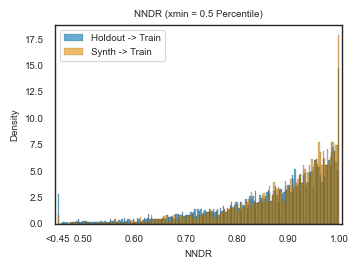

In [19]:
plot_nndr_distribution(plot_holdout_train, plot_syn_train, label_1='Holdout -> Train', label_2='Synth -> Train', title='NNDR (xmin = 0.5 Percentile)', fig_size=(3.6, 2.7), save_fig=cfg.save_data)

Abbildung gespeichert unter: figures\NNDR_Stability_Synth-Train_n-100_s-5000_20250601_100120.tiff


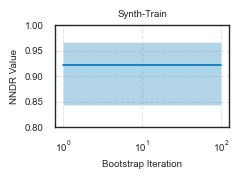

Abbildung gespeichert unter: figures\NNDR_Stability_Synth-Holdout_n-100_s-5000_20250601_100120.tiff


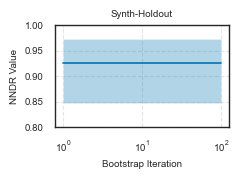

Abbildung gespeichert unter: figures\NNDR_Stability_Holdout-Train_n-100_s-5000_20250601_100120.tiff


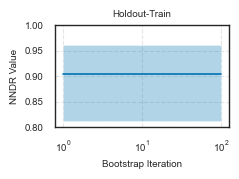

In [26]:
plot_bootstrap_stabilization(plot_syn_train, sample_size=cfg.bootstrap_size, log_scale=True, ci_band=True, title='Synth-Train', save_fig=cfg.save_data)
plot_bootstrap_stabilization(plot_syn_holdout, sample_size=cfg.bootstrap_size, title='Synth-Holdout', save_fig=cfg.save_data)
plot_bootstrap_stabilization(plot_holdout_train, sample_size=cfg.bootstrap_size, title='Holdout-Train', save_fig=cfg.save_data)